In [1]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 15 kB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score

In [6]:
df_train = pd.read_csv("/content/train_dataset_train.csv").rename(columns={'id': 'user_id'})
# df_decision = pd.read_csv("/content/decision.csv")
df_user_dec = pd.read_csv("/content/user_decision.csv")
df_user = pd.read_csv("/content/user.csv")
df_team_point = pd.read_csv("/content/team_point.csv")
df_sample_sol = pd.read_csv("/content/sample_solution.csv").rename(columns={'id': 'user_id'})

In [7]:
df_team_point = pd.read_csv("/content/team_point.csv")
set(df_team_point["period"])

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [8]:
df_train.iloc[0:3]

,user_id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0


In [9]:
df_user_dec.iloc[0:3]

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420


In [10]:
df_user.iloc[0:3]

,user_id,team_id,game_id
0,10189,1664,235
1,10018,1690,237
2,10580,1394,194


In [11]:
df_sample_sol.iloc[0:3]

,user_id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0


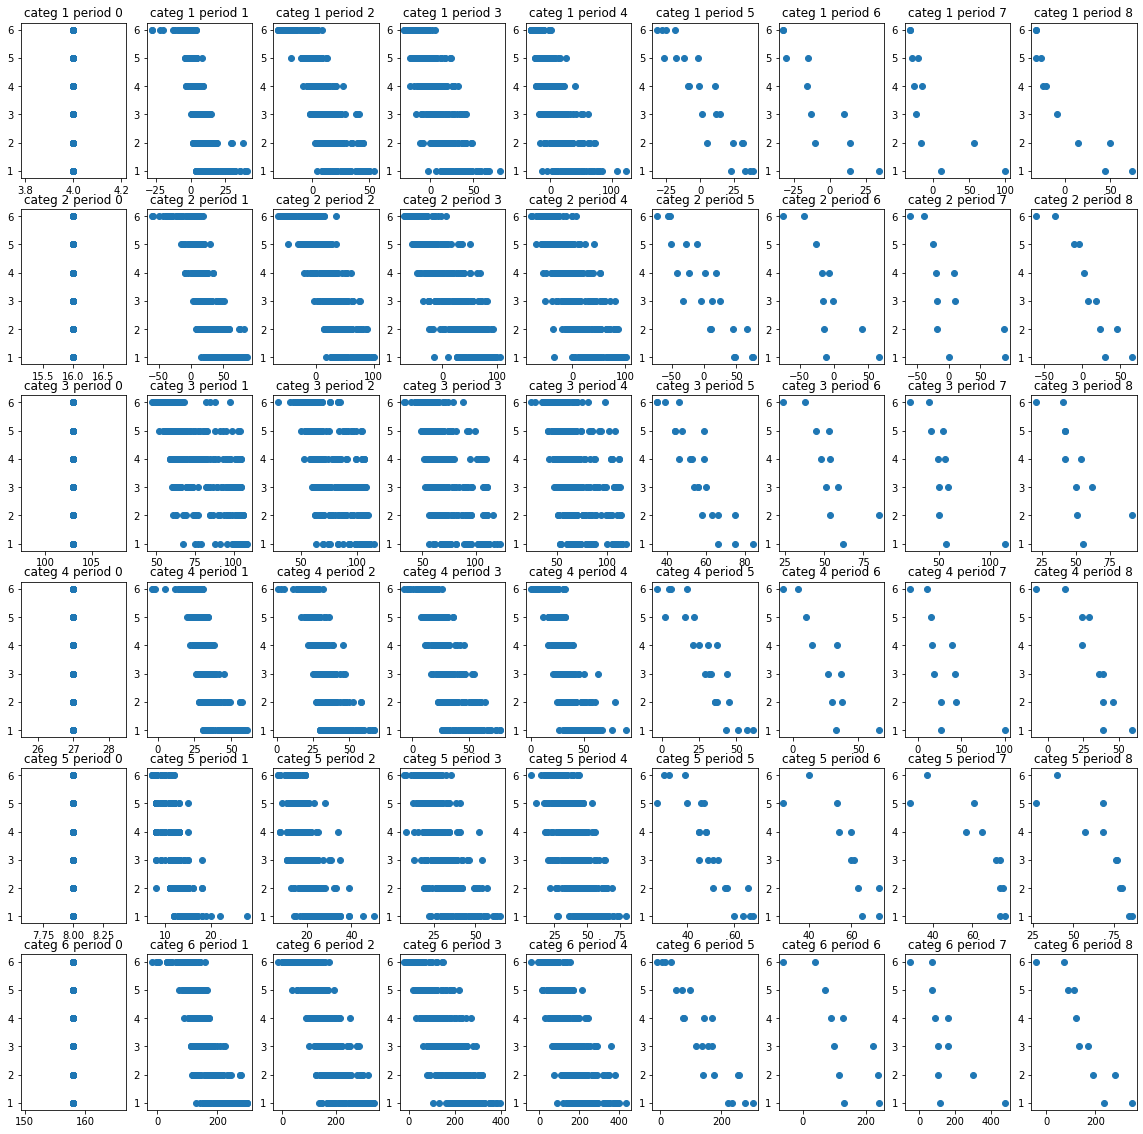

In [12]:
fig = plt.figure(figsize =(20,20))
for i in set(df_team_point["category_id"]):
  for j in set(df_team_point["period"]):

    ax = fig.add_subplot(6, 9, 9*(i-1)+j+1)
    ax.scatter(df_team_point[(df_team_point["category_id"]==i) & (df_team_point["period"]==j)]["score"],
                df_team_point[(df_team_point["category_id"]==i) & (df_team_point["period"]==j)]["place"])
    ax.set_title(f"categ {i} period {j}")


In [22]:
df_train_cat = pd.merge(df_user_dec, df_train, on=["user_id"], how = "inner")
df_train_cat = df_train_cat.drop_duplicates()
df_train_cat = df_train_cat.reset_index()
df_train_cat = df_train_cat.drop(["index"], axis=1)
# df_train_cat[df_train_cat[["Analytical thinking","Systemic thinking","Adaptability","Focus"]] > 5] = 5

TRAIN CATBOOST

In [23]:
user = set(df_train_cat["user_id"])
# dec = set(df_train_cat["decision_id"]) 
# per = set(df_train_cat["period"])
cat_features2 = np.zeros((len(user), 438))
user2 = np.array(list(user))

for raw in range(len(df_train_cat["user_id"])):
  for id in user2:

    if df_train_cat["user_id"][raw] == id:
      rawn = np.where(user2 == id)
      col = df_train_cat["decision_id"][raw]
      cat_features2[rawn, col] = df_train_cat["decision_id"][raw]

In [24]:
df_cat_features2 = pd.DataFrame(cat_features2, index = user2)
df_cat_features2["user_id"] = df_cat_features2.index

df_train_cat2 = df_train_cat[["Analytical thinking","Systemic thinking","Adaptability","Focus", "user_id"]].drop_duplicates()
df_train_cat2 = df_train_cat.reset_index()
df_train_cat_features2 = pd.merge(df_cat_features2, df_train_cat, how = "inner")

X = df_train_cat_features2.drop(["Analytical thinking","Systemic thinking","Adaptability","Focus","user_id"], axis = 1)
y = df_train_cat_features2[["Analytical thinking","Systemic thinking","Adaptability","Focus"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

TEST PUBLIC

In [ ]:
user = set(df_user_dec["user_id"])
# dec = set(df_user_dec["decision_id"])
per = set(df_user_dec["period"])
sol = np.zeros((len(user), 438))
user2 = np.array(list(user))

for raw in range(len(df_user_dec["user_id"])):
  for id in user2:

    if df_user_dec["user_id"][raw] == id:
      rawn = np.where(user2 == id)
      col =df_user_dec["decision_id"][raw]
      sol[rawn, col] = df_user_dec["decision_id"][raw]

In [ ]:
df_sol = pd.DataFrame(sol, index = user2)
df_sol["user_id"] = df_sol.index

df_test = pd.merge(df_sol, df_sample_sol, how="inner", on=["user_id"])
test_ind = df_test["user_id"]
df_test = df_test.drop(["Analytical thinking","Systemic thinking","Adaptability","Focus", "user_id"], axis=1)

In [ ]:
df_test.shape

In [ ]:
model_P1 = CatBoostClassifier(iterations=10,
                           learning_rate= 0.1,
                           loss_function='MultiClass',
                           random_seed=42,
                           depth=10)        
model_P1.fit(X_train, y_train["Analytical thinking"],
         eval_set=(X_test, y_test["Analytical thinking"]),
          verbose=False)
predict_P1 = model_P1.predict(df_test)    
test_P1 = model_P1.predict(X_test)    

In [ ]:
model_P1.plot_tree(
    tree_idx=0)

In [ ]:
model_P2 = CatBoostClassifier(iterations=10,
                           learning_rate= 0.1,
                           loss_function='MultiClass',
                           random_seed=42,
                           depth=10) 
model_P2.fit(X_train, y_train["Systemic thinking"],
         eval_set=(X_test, y_test["Systemic thinking"]),
          verbose=False)
predict_P2 = model_P2.predict(df_test) 
test_P2 = model_P2.predict(X_test)    

In [ ]:
model_P3 = CatBoostClassifier(iterations=10,
                           learning_rate= 0.1,
                           loss_function='MultiClass',
                           random_seed=42,
                           depth=10)  
model_P3.fit(X_train, y_train["Adaptability"],
         eval_set=(X_test, y_test["Adaptability"]),
          verbose=False)
predict_P3 = model_P3.predict(df_test) 
test_P3 = model_P3.predict(X_test)    

In [ ]:
model_P4 = CatBoostClassifier(iterations=510,
                           learning_rate= 0.1,
                           loss_function='MultiClass',
                           random_seed=42,
                           depth=10)  
model_P4.fit(X_train, y_train["Focus"],
         eval_set=(X_test, y_test["Focus"]),
          verbose=False)
predict_P4 = model_P4.predict(df_test) 
test_P4 = model_P4.predict(X_test)   

In [ ]:
recall1 = recall_score(test_P1, y_test["Analytical thinking"], average='micro')
print(f"Analytical {recall1}")
recall2 = recall_score(test_P2, y_test["Systemic thinking"], average='micro')
print(f"Systemic thinking {recall2}")
recall3 = recall_score(test_P3, y_test["Adaptability"], average='micro')
print(f"Adaptability {recall3}")
recall4 = recall_score(test_P4, y_test["Focus"], average='micro')
print(f"Focus {recall4}")
Recall = (recall1+recall2+recall3+recall4)/4
print(f"Recall = {Recall}")

In [ ]:
p1 = list(predict_P1).replace('[','').replace(']','')
p2 = list(predict_P2).replace('[','').replace(']','')
p3 = list(predict_P3).replace('[','').replace(']','')
p4 = list(predict_P4).replace('[','').replace(']','')

In [ ]:
df_sample_sol_file = pd.DataFrame(np.array([np.array(test_ind), p1, p2, p3, p4]).T,
                                  columns=["id", "Analytical thinking","Systemic thinking","Adaptability","Focus"])

In [85]:
df_sample_sol_file.to_csv("solution.csv", index=False)